<a href="https://colab.research.google.com/github/bbwolcott/nyu-python-public-policy/blob/master/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem Statement: Homelesses is a big concern in New York City. The Department of Homeless Services is tasked with providing services and housing for people who are homeless. They recently began publishing the count of homeless shelter buildings per community district on NYC Open Data to provide more transparency into where shelters are located. The dataset provides counts in multiple columns for different categories of buildings. It also includes counts from different reporting dates.

The 311 Service Requests dataset includes a complaint type called "Homeless Person Assistance". Let's find out if there's a relationship between the number of homeless assistance 311 requests and the concentration of homeless shelter buildings per community district.

**Step 1**. Load the datasets:
- Cleaned 311 data that excludes records with invalid community districts. Shared with you on Google Drive as `cleaned_311_data_revised.csv`
- NYC Open dataset that provides the total count of different types of homeless shelter buildings per community district. 
  - Data source page where you can preview the data: https://data.cityofnewyork.us/Social-Services/Buildings-by-Borough-and-Community-District/3qem-6v3v/data
  - CSV data download link you can plug into the `pd.read_csv()` function: https://data.cityofnewyork.us/api/views/3qem-6v3v/rows.csv?accessType=DOWNLOAD

In [0]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt 
import numpy as np
import statsmodels.api as sm

In [0]:
# You can use pd.set_option() to make sure you see all the rows and columns in your dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [102]:
df = pd.read_csv('/content/drive/My Drive/Data for Python/cleaned_311_data_revised.csv', header='infer')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,19,20,22,33,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
shelter_buildings = pd.read_csv('https://data.cityofnewyork.us/api/views/3qem-6v3v/rows.csv?accessType=DOWNLOAD', header='infer')

**Step 2**. Filter the shelter count dataframe to only keep rows where the value in the 'Report Date' column is '09/30/2019'

In [0]:
shelter_buildings = shelter_buildings[shelter_buildings['Report Date'] == '09/30/2019']

In [105]:
shelter_buildings.head()

,Report Date,Borough,Community District,Adult Family Comm Hotel,Adult Family Shelter,Adult Shelter,Adult Shelter Comm Hotel,FWC Cluster,FWC Comm Hotel,FWC Shelter
624,09/30/2019,Bronx,201,NaN,1.0,2.0,NaN,4.0,1.0,7.0
625,09/30/2019,Bronx,202,NaN,1.0,NaN,NaN,2.0,NaN,5.0
626,09/30/2019,Bronx,203,NaN,3.0,6.0,NaN,3.0,2.0,9.0
627,09/30/2019,Bronx,204,NaN,NaN,2.0,1.0,14.0,NaN,15.0
628,09/30/2019,Bronx,205,NaN,1.0,3.0,NaN,12.0,NaN,5.0


**Step 3**. Create a new column in the shelter count dataframe that calculates the sum of all the individual count columns: 'Adult Family Comm Hotel', 'Adult Family Shelter', 'Adult Shelter', 'Adult Shelter Comm Hotel', 'FWC Cluster', 'FWC Comm Hotel', 'FWC Shelter'

- Tip: There are multiple ways to add these columns together. With one approach, you may find that your total column contains NaN values. This is because many of the columns contains NaN/empty values. When you add a real number to a NaN, the sum will be NaN. To get around this, you will need to fill in all the NaN values with 0 instead. Use the `.fillna(0)` method on your shelter count dataframe.

In [106]:
shelter_buildings = shelter_buildings.fillna(0)
shelter_buildings['count'] = shelter_buildings.iloc[:, 3:10].sum(axis=1)
shelter_buildings.head()

,Report Date,Borough,Community District,Adult Family Comm Hotel,Adult Family Shelter,Adult Shelter,Adult Shelter Comm Hotel,FWC Cluster,FWC Comm Hotel,FWC Shelter,count
624,09/30/2019,Bronx,201,0.0,1.0,2.0,0.0,4.0,1.0,7.0,15.0
625,09/30/2019,Bronx,202,0.0,1.0,0.0,0.0,2.0,0.0,5.0,8.0
626,09/30/2019,Bronx,203,0.0,3.0,6.0,0.0,3.0,2.0,9.0,23.0
627,09/30/2019,Bronx,204,0.0,0.0,2.0,1.0,14.0,0.0,15.0,32.0
628,09/30/2019,Bronx,205,0.0,1.0,3.0,0.0,12.0,0.0,5.0,21.0


**Step 4**. From the 311 dataset, create a subset of all the 311 requests where `complaint_type == 'Homeless Person Assistance'`

In [107]:
df = df[df.complaint_type == 'Homeless Person Assistance']
df.head()

,Unnamed: 0,Unnamed: 0.1,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,address_type,city,landmark,facility_type,status,due_date,resolution_description,resolution_action_updated_date,community_board,bbl,borough,x_coordinate_(state_plane),y_coordinate_(state_plane),open_data_channel_type,park_facility_name,park_borough,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location,borocd
0,0,0,39888071,08/01/2018 12:00:10 AM,08/01/2018 01:52:46 AM,DHS,Operations Unit - Department of Homeless Services,Homeless Person Assistance,NaN,Other,10029,200 EAST 109 STREET,EAST 109 STREET,3 AVENUE,2 AVENUE,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,08/01/2018 01:00:10 AM,The mobile outreach response team offered serv...,08/01/2018 01:52:46 AM,11 MANHATTAN,1.016560e+09,MANHATTAN,1000049.0,228317.0,MOBILE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.793339,-73.942942,"(40.79333937834769, -73.9429417746998)",111.0
46,46,46,39887175,08/01/2018 12:15:12 AM,08/01/2018 01:29:09 AM,DHS,Operations Unit - Department of Homeless Services,Homeless Person Assistance,NaN,Street/Sidewalk,10016,478 THIRD AVENUE,THIRD AVENUE,EAST 32 STREET,EAST 33 STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,08/01/2018 01:15:12 AM,The mobile outreach response team offered serv...,08/01/2018 01:29:09 AM,06 MANHATTAN,1.008880e+09,MANHATTAN,990113.0,210611.0,MOBILE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.744753,-73.978841,"(40.74475319239264, -73.97884116795397)",106.0
47,47,47,39883411,08/01/2018 12:15:39 AM,08/01/2018 01:33:51 AM,DHS,Operations Unit - Department of Homeless Services,Homeless Person Assistance,NaN,Residential Building/House,10035,445 EAST 120 STREET,EAST 120 STREET,1 AVENUE,PLEASANT AVENUE,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,08/01/2018 01:15:39 AM,The mobile outreach response team went to the ...,08/01/2018 01:33:51 AM,11 MANHATTAN,1.018080e+09,MANHATTAN,1003119.0,229980.0,MOBILE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.797898,-73.931850,"(40.797897839118114, -73.93184977463629)",111.0
145,150,150,39881402,08/01/2018 12:59:43 AM,08/01/2018 02:10:40 AM,DHS,Operations Unit - Department of Homeless Services,Homeless Person Assistance,NaN,Street/Sidewalk,10027,624 WEST 125 STREET,WEST 125 STREET,BROADWAY,ST CLAIR PLACE,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,08/01/2018 01:59:43 AM,The mobile outreach response team went to the ...,08/01/2018 02:10:40 AM,09 MANHATTAN,1.019950e+09,MANHATTAN,995623.0,236699.0,MOBILE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.816352,-73.958912,"(40.81635246371125, -73.95891211015879)",109.0
371,394,394,39888951,08/01/2018 04:10:47 AM,08/01/2018 05:18:59 AM,DHS,Operations Unit - Department of Homeless Services,Homeless Person Assistance,NaN,Street/Sidewalk,10003,115 EAST 14 STREET,EAST 14 STREET,4 AVENUE,IRVING PLACE,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Closed,08/01/2018 05:10:47 AM,The individual was found and outreach assistan...,08/01/2018 05:18:59 AM,05 MANHATTAN,1.008708e+09,MANHATTAN,987266.0,206735.0,PHONE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.734116,-73.989117,"(40.73411596377878, -73.98911737171056)",105.0


**Step 5**. Group the 311 subset by 'borocd' to get the count of 'Homeless Person Assistance' requests per community district

In [0]:
df=df.groupby('borocd').size().reset_index(name='Homeless Requests')

In [109]:
df.head()

,borocd,Homeless Requests
0,101.0,758
1,102.0,965
2,103.0,520
3,104.0,1055
4,105.0,3020


**Step 6**. Merge the homeless 311 request count table (from Step 5) with the shelter count table (from Step 3).
- Tip: Not all community districts have homeless facilities in them. Use a left join with the 311 complaints as the left table and shelter counts as the right table. After doing this, you should fill in the new NaNs with zeros using the `.fillna(0)` method on your dataframe.

In [0]:
#Data issue with repeating Bronx data in the Shelter dataset
shelter_buildings=shelter_buildings.loc[624:675,:]

In [111]:
shelter_buildings.head(80)

,Report Date,Borough,Community District,Adult Family Comm Hotel,Adult Family Shelter,Adult Shelter,Adult Shelter Comm Hotel,FWC Cluster,FWC Comm Hotel,FWC Shelter,count
624,09/30/2019,Bronx,201,0.0,1.0,2.0,0.0,4.0,1.0,7.0,15.0
625,09/30/2019,Bronx,202,0.0,1.0,0.0,0.0,2.0,0.0,5.0,8.0
626,09/30/2019,Bronx,203,0.0,3.0,6.0,0.0,3.0,2.0,9.0,23.0
627,09/30/2019,Bronx,204,0.0,0.0,2.0,1.0,14.0,0.0,15.0,32.0
628,09/30/2019,Bronx,205,0.0,1.0,3.0,0.0,12.0,0.0,5.0,21.0
629,09/30/2019,Bronx,206,0.0,1.0,2.0,1.0,3.0,0.0,19.0,26.0
630,09/30/2019,Bronx,207,0.0,1.0,5.0,0.0,4.0,0.0,3.0,13.0
631,09/30/2019,Bronx,208,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
632,09/30/2019,Bronx,209,0.0,0.0,1.0,0.0,5.0,0.0,2.0,8.0
633,09/30/2019,Bronx,210,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0


In [0]:
merged = pd.merge(left=df, right=shelter_buildings, left_on='borocd', right_on='Community District', how='left')

In [0]:
merged = merged.fillna(0)

In [114]:
merged.tail()

,borocd,Homeless Requests,Report Date,Borough,Community District,Adult Family Comm Hotel,Adult Family Shelter,Adult Shelter,Adult Shelter Comm Hotel,FWC Cluster,FWC Comm Hotel,FWC Shelter,count
54,413.0,39,09/30/2019,Queens,413.0,0.0,0.0,0.0,5.0,0.0,2.0,2.0,9.0
55,414.0,53,09/30/2019,Queens,414.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0
56,501.0,41,09/30/2019,Staten Island,501.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
57,502.0,34,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,503.0,18,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Step 7**. Produce a scatter plot of the data using the `matplotlib` package. What is your initial impression on whether there is a correlation between number of shelters and count of 311 homeless service requests?

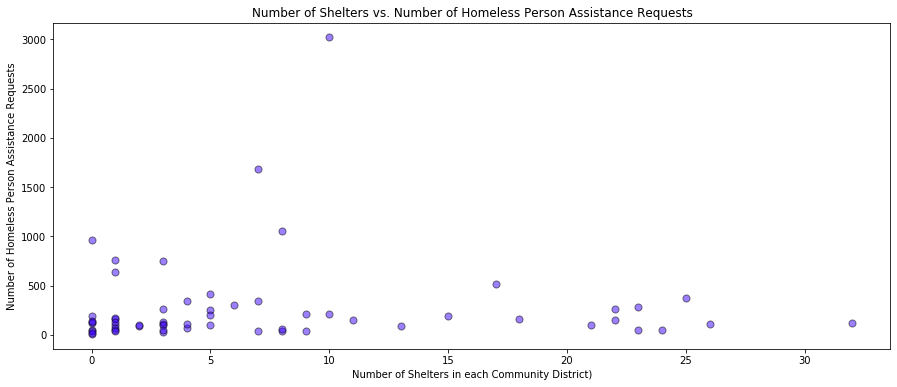

In [115]:
plt.figure(figsize=(15, 6))

plt.scatter(
    np.array(merged['count']), 
    np.array(merged['Homeless Requests']),
    s=50,
    c='#3d03fc',
    edgecolors='black',
    alpha=0.5)

plt.title('Number of Shelters vs. Number of Homeless Person Assistance Requests')
plt.xlabel('Number of Shelters in each Community District)')
plt.ylabel('Number of Homeless Person Assistance Requests')

plt.show()

It does not appear there is a coorelation between the number of shelters in each community district and the number of Homeless Person Assistance 311 requests.

**Step 8**. Use `np.corrcoef(x, y)` to identify the correlation coefficient between count of total shelter buildings and count of homeless requests per community district.

In [116]:
x = np.array(merged['count'])
y = np.array(merged['Homeless Requests'])
np.corrcoef(x,y)

array([[1.        , 0.01073618],
       [0.01073618, 1.        ]])

**Step 9**. Perform a linear regression with count of total shelter buildings as the independent variable and count of homeless requests as the dependent variable

In [117]:
# x = Add a constant 
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()

# Print out the statistics

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                  0.006571
Date:                Sat, 30 Nov 2019   Prob (F-statistic):              0.936
Time:                        22:05:35   Log-Likelihood:                -445.94
No. Observations:                  59   AIC:                             895.9
Df Residuals:                      57   BIC:                             900.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        274.4772     83.126      3.302      0.0

**Step 10**. Produce a scatter plot of the data with the line of best fit from your linear regression using the `matplotlib` package

In [118]:
p = model.params # intercept and coefficient
print('parameters:', p)

r2 = model.rsquared
print('R2:', r2)

parameters: [274.47717459   0.59920962]
R2: 0.00011526563489161479


In [119]:
# let's make labels for the lines of the best fit to use on a scatter plot

label = 'y = ' + str(round(p[1],2)) + 'x + ' + str(round(p[0],2)) + '; R2 = ' + str(round(r2,3))
print(label)

y = 0.6x + 274.48; R2 = 0.0


In [0]:
x_dummy = np.array(merged['count'])

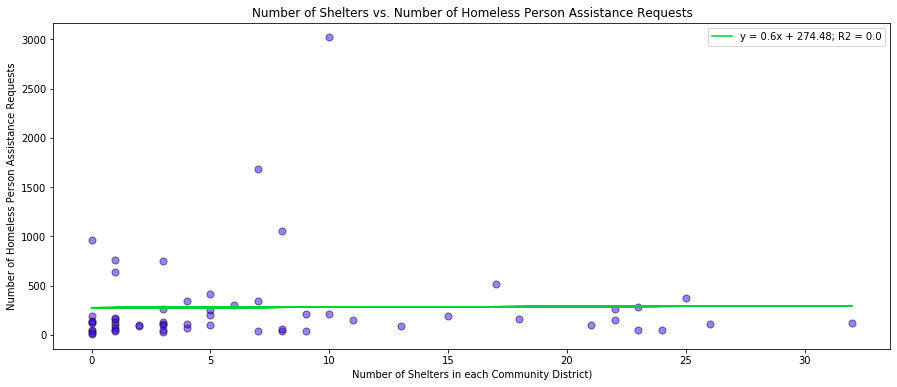

In [121]:
plt.figure(figsize=(15, 6))

plt.scatter(
    np.array(merged['count']), 
    np.array(merged['Homeless Requests']),
    s=50,
    c='#3d03fc',
    edgecolors='black',
    alpha=0.5)

# line of best fit, with y intercept
plt.plot(
    x_dummy, 
    p[0] + p[1] * x_dummy,
    c='#00d138',
    label=label)

plt.title('Number of Shelters vs. Number of Homeless Person Assistance Requests')
plt.xlabel('Number of Shelters in each Community District)')
plt.ylabel('Number of Homeless Person Assistance Requests')
plt.legend()

plt.show()

**Step 11**: Write a sentence or two explaining the results of your analysis. What do the numbers and chart tell you about the relationship between concentration of homeless shelters vs. frequency of 311 requests related to homelessness?

I do not find a correlation between concentration of homeless shelters vs. frequency of 311 requests related to homelessness. While one might expect to see a positive relationship, the p-value is not statistically significant, and the r-squared is an extremely low .0001, which means the model explains approximately none of the variation. To explain the lack of relationship, it may be helpful to examine Community District 5 in Manhattan, the area with the largest number of requests. This area includes Times Square and potentially has many homeless people and requests because it is a tourist area. That being said, it does not have very many homeless shelters despite the need possibly because property values are high.